# Chloropleth Maps Using geopandas

I've always found chloropleth maps (a map where regions are shaded in proportion to a statistical variable) to be very compelling. They're very easy to interpret, and are a good way of presenting data in relation to geographical location. With geopandas and matplotlib, we can make chloropleth maps in python. I found a dataset in Kaggle with air pollution data in Seoul by district, which will be a good dataframe to make our maps.

In this notebook, we make use of a shapefile of Seoul. Our shapefile represents geographical locations as polygon areas. These polygons can be plotted, and shaded based on the statistical data we'll be working with. A repository with this file can be found here: https://github.com/southkorea/seoul-maps

The air-pollution-in-seoul dataset has many metrics for air pollution. We'll be focusing on particulate matter levels $PM_{10}$ and $PM_{2.5}$. Here are the WHO guidelines for particulate matter:

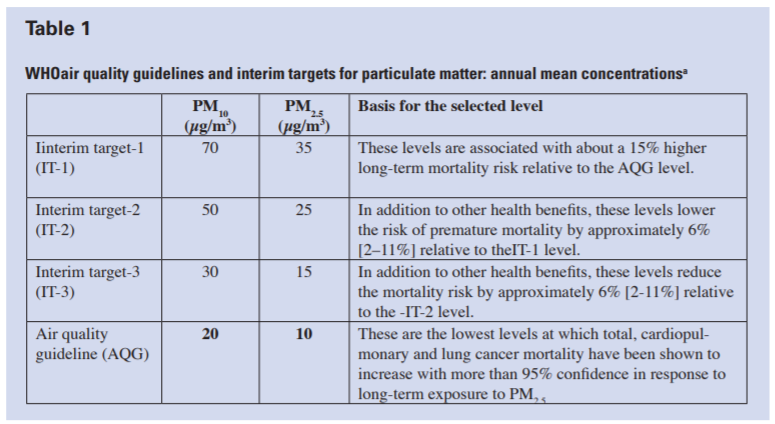

Learn more about PM here: https://www.epa.gov/pm-pollution/particulate-matter-pm-basics

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv("/kaggle/input/air-pollution-in-seoul/AirPollutionSeoul/Measurement_summary.csv")
measurement_info = pd.read_csv("/kaggle/input/air-pollution-in-seoul/AirPollutionSeoul/Original Data/Measurement_item_info.csv")
fp = "/kaggle/input/seoulmap/seoul_municipalities.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [ ]:
Seoul_PM = df[['Measurement date', 'Station code','Address', 'PM10','PM2.5']]
districts = []
for address in Seoul_PM.Address:
    split_address = address.split(", ")
    districts += [split_address[2]]
districts = list(dict.fromkeys(districts))

In [ ]:
Seoul_PM['Measurement date'] = pd.to_datetime(Seoul_PM['Measurement date'])

I'm certain there's a cleaner way to accomplish what I did here. I'm writing this a little while after the fact, so if I were to do it again now, I would try to use groupby to organize by year and by districts, and then get the yearly averages by . As it is here, I used boolean indexing to create separate dataframes by year, then found the means of $PM_{10}$ and $PM_{2.5}$ in each district in a for loop, which are stored with the district names in a list, which is nested in another list, which is THEN merged with the shapefile dataframe through a join. This is repeated for each year, and we use the merged dataframe to plot the map.

Not the best way to do things, but I guess it got the job done!

Looking over the dataframe, I saw some values that were 0 and negative. This doesn't make physical sense, so I excluded these values from the dataframe. 

In [ ]:
Seoul2019_PM = Seoul_PM[Seoul_PM["Measurement date"] >= '2019']
Seoul2019_PM = Seoul2019_PM[Seoul2019_PM["PM10"] > 0]
Seoul2019_PM = Seoul2019_PM[Seoul2019_PM["PM2.5"] > 0]

stations_average_2019PM = []
for station in Seoul2019_PM["Station code"].unique():
    station_n = Seoul2019_PM[Seoul2019_PM["Station code"] == station]
    station_n = station_n[["PM10","PM2.5"]].mean(axis = 0)
    stations_average_2019PM += [list(station_n)]

for i in range(0,len(stations_average_2019PM)):
    stations_average_2019PM[i].insert(0,districts[i])

district_averages_2019 = pd.DataFrame(stations_average_2019PM, columns = ["District","PM10_AVG","PM2.5_AVG"])
merged = map_df.set_index('SIG_ENG_NM').join(district_averages_2019.set_index('District'))

With our map dataframe ready, we can plot our variable onto it with matplotlib. We'll normalize the colormap and color bar based on the range of PM levels defined by the WHO (10-40 micrograms for $PM_{2.5}$, 20-70 micrograms for $PM_{10}$).

In [ ]:
vmin10, vmax10 = 20,70 
vim25, vmax25 = 10,40

variable1 = "PM10_AVG" 
variable2 = "PM2.5_AVG"

fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm10 = colors.TwoSlopeNorm(vmin = 20, vcenter = 45, vmax=70) 
cbar = plt.cm.ScalarMappable(norm=divnorm10, cmap='Reds')

ax.axis('off')

merged.plot(column=variable1, cmap='Reds', linewidth=0.8, ax=ax, norm = divnorm10, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])
ax.set_title('Seoul 2019 Average $PM_{10}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([20,30,40,50,60,70])
clb.set_ticklabels(['< 20','30','40','50','60','> 70'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm25 = colors.TwoSlopeNorm(vmin = 10, vcenter = 25, vmax=40) 
cbar = plt.cm.ScalarMappable(norm=divnorm25, cmap='Oranges')

ax.axis('off')

merged.plot(column=variable2, cmap='Oranges', linewidth=0.8, ax=ax, norm = divnorm25, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])

ax.set_title('Seoul 2019 Average $PM_{2.5}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)
#plt.text(126.75,37.697,"2019", fontsize = 18)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([10,15,20,25,30,35,40])
clb.set_ticklabels(['< 10','15','20','25','30','35','> 40'])
#clb.set_label('Micrograms per Cubic Meter', rotation=270, labelpad = 28)
plt.show()

Neat, now let's do the same for 2018 and 2017

In [ ]:
Seoul2018_PM = Seoul_PM[Seoul_PM["Measurement date"] >= '2018']
Seoul2018_PM = Seoul2018_PM[Seoul_PM["Measurement date"] < '2019']
Seoul2018_PM = Seoul2018_PM[Seoul2018_PM["PM10"] > 0]
Seoul2018_PM = Seoul2018_PM[Seoul2018_PM["PM2.5"] > 0]

#Seoul2018_PM
stations_average_2018PM = []
for station in Seoul2018_PM["Station code"].unique():
    station_n = Seoul2018_PM[Seoul2018_PM["Station code"] == station]
    station_n = station_n[["PM10","PM2.5"]].mean(axis = 0)
    stations_average_2018PM += [list(station_n)]
    
stations_average_2018PM

for i in range(0,len(stations_average_2019PM)):
    stations_average_2018PM[i].insert(0,districts[i])

district_averages_2018 = pd.DataFrame(stations_average_2018PM, columns = ["District","PM10_AVG","PM2.5_AVG"])
merged2 = map_df.set_index('SIG_ENG_NM').join(district_averages_2018.set_index('District'))

In [ ]:
vmin10, vmax10 = 20,70 
vim25, vmax25 = 10,40

variable1 = "PM10_AVG" 
variable2 = "PM2.5_AVG"

fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm10 = colors.TwoSlopeNorm(vmin = 20, vcenter = 45, vmax=70) 
cbar = plt.cm.ScalarMappable(norm=divnorm10, cmap='Reds')

ax.axis('off')

merged2.plot(column=variable1, cmap='Reds', linewidth=0.8, ax=ax, norm = divnorm10, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])
ax.set_title('Seoul 2018 Average $PM_{10}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([20,30,40,50,60,70])
clb.set_ticklabels(['< 20','30','40','50','60','> 70'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm25 = colors.TwoSlopeNorm(vmin = 10, vcenter = 25, vmax=40) 
cbar = plt.cm.ScalarMappable(norm=divnorm25, cmap='Oranges')

ax.axis('off')

merged2.plot(column=variable2, cmap='Oranges', linewidth=0.8, ax=ax, norm = divnorm25, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])

ax.set_title('Seoul 2018 Average $PM_{2.5}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)
#plt.text(126.75,37.697,"2019", fontsize = 18)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([10,15,20,25,30,35,40])
clb.set_ticklabels(['< 10','15','20','25','30','35','> 40'])
#clb.set_label('Micrograms per Cubic Meter', rotation=270, labelpad = 28)
plt.show()

In [ ]:
Seoul2017_PM = Seoul_PM[Seoul_PM["Measurement date"] < '2018']
Seoul2017_PM = Seoul2017_PM[Seoul2017_PM["PM10"] > 0]
Seoul2017_PM = Seoul2017_PM[Seoul2017_PM["PM2.5"] > 0]

stations_average_2017PM = []
for station in Seoul2017_PM["Station code"].unique():
    station_n = Seoul2017_PM[Seoul2017_PM["Station code"] == station]
    station_n = station_n[["PM10","PM2.5"]].mean(axis = 0)
    stations_average_2017PM += [list(station_n)]
    
stations_average_2017PM

for i in range(0,len(stations_average_2017PM)):
    stations_average_2017PM[i].insert(0,districts[i])
stations_average_2017PM

district_averages_2017 = pd.DataFrame(stations_average_2017PM, columns = ["District","PM10_AVG","PM2.5_AVG"])
merged3 = map_df.set_index('SIG_ENG_NM').join(district_averages_2017.set_index('District'))

In [ ]:
vmin10, vmax10 = 20,70 
vim25, vmax25 = 10,40

variable1 = "PM10_AVG" 
variable2 = "PM2.5_AVG"

fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm10 = colors.TwoSlopeNorm(vmin = 20, vcenter = 45, vmax=70) 
cbar = plt.cm.ScalarMappable(norm=divnorm10, cmap='Reds')

ax.axis('off')

merged3.plot(column=variable1, cmap='Reds', linewidth=0.8, ax=ax, norm = divnorm10, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])
ax.set_title('Seoul 2017 Average $PM_{10}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([20,30,40,50,60,70])
clb.set_ticklabels(['< 20','30','40','50','60','> 70'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 9))

divnorm25 = colors.TwoSlopeNorm(vmin = 10, vcenter = 25, vmax=40) 
cbar = plt.cm.ScalarMappable(norm=divnorm25, cmap='Oranges')

ax.axis('off')

merged3.plot(column=variable2, cmap='Oranges', linewidth=0.8, ax=ax, norm = divnorm25, edgecolor='0.8') 
plt.xticks([])
plt.yticks([])

ax.set_title('Seoul 2017 Average $PM_{2.5}$ (\u03bcg/$m^{3}$)', fontdict={'fontsize': '18', 'fontweight' : '3'}, pad = 10)
#plt.text(126.75,37.697,"2019", fontsize = 18)

clb = plt.colorbar(cbar,fraction=0.046, pad=0.04)
clb.set_ticks([10,15,20,25,30,35,40])
clb.set_ticklabels(['< 10','15','20','25','30','35','> 40'])
#clb.set_label('Micrograms per Cubic Meter', rotation=270, labelpad = 28)
plt.show()

Just for kicks, lets do a rolling average plot for Songpa-gu, the most populous district. We'll do a 30 day rolling average from 2017 to 2019. To facilitate this, made a dataframe for each districts in the main dataframe, which is then stored in a dictionary with the districts as indexes. With this dictionary, it's pretty easy to select district data by name.

In [ ]:
clean_seoul = df[df["PM10"] > 0]
clean_seoul = df[df["PM2.5"] > 0]
clean_seoul['Measurement date'] = pd.to_datetime(clean_seoul['Measurement date'])

In [ ]:
addresses = list(clean_seoul.Address.unique())

df_dict = {}
for i in range(len(districts)):
    gu_n = clean_seoul[clean_seoul["Address"] == addresses[i]]
    df_dict.setdefault(districts[i], gu_n)

songpa_gu = df_dict["Songpa-gu"].set_index("Measurement date")

CMA_10 = songpa_gu["PM10"].rolling("30D").mean()
CMA = songpa_gu["PM2.5"].rolling("30D").mean()

fig = plt.figure(figsize=(10,6))
CMA.plot(color = "orange",label = "$PM_{2.5}$")
CMA_10.plot(color = "blue",label = "$PM_{10}$")
plt.legend(loc="upper left")
plt.xlabel("Date",labelpad = 20, fontsize = 13)
plt.ylabel("Particulate Matter (\u03bcg/$m^{3}$)",fontsize = 13)
plt.title("Songpa-Gu Particulate Matter 2017-2019\n(30 Day Rolling Average)", fontsize=18, pad=10)
plt.show()